# Program to find emperical kinetic parameters from experimental data

## Settings to edit

In [81]:
####Data sets to imported

##Data for VSMC proliforation due to NO conc
#Tanner, F. C, T. F. (2000)
#Tanner_x = [0,1.00E+01,1.00E+02,1.00E+03]
Tanner_x = [0,1.00E-05,1.00E-04,1.00E-03]
#shifted
Tanner_y = [0.017821644,0.017304915,0.013248376,9.49536E-06]
Tanner_y_err = [0.000444829,0.000530232,0.000596935,0.000774962]


#Do you only want to consider only 1 data set? - if so set this to 1
no_datasets = 1
#Input lists of data sets that you want to use
if no_datasets == 1:
    ###Data sets to use
    xdata_sets = [Tanner_x]
    #ydata
    ydata_sets = [Tanner_y]
    #yerr data sets
    yerr_sets = [Tanner_y_err]
else:
    ###Data sets to use
    #xdata_sets = [Morb_VEGF_conc,Myoken_VEGF_conc,Bussolati_VEGF_conc]
    #ydata
    #ydata_sets = [Morb_prolif,Myoken_prolif,Bussolati_prolif]
    #yerr data sets
    #yerr_sets = [Morb_prolif_err,Myoken_prolif_err,Bussolati_prolif_err]
    pass

#If you are using multiple data sets, do you want to scale them along the y axis to account for variation which occours due to maximum production rates
scale = 'Yes'


####Fitting Options
#Do you want to use estimated variables? - If you are getting a bad fit try fitting without using estimated variables
#If you are not using the estimated variables, check the fitted parameters to make sure that they make sense
Estimated_var = 'No'

#Do you have measureed error
error = 'Yes'

##What features do you need for fitting? - Note you can only add basal production with logistic growth
##Pick one of these
#Do you have logistic growth or production of the cell signalling molecule 
log_growth = 'No'
#If you have logistic growth, do you have basal production too?
basal = 'Yes'
#Do you have exponential growth?
exp_growth = 'No'
#Do you logistic decay - must have basal set to yes
inverse_log = 'Yes'
#What is your minimum acceptable R^2 value
min_r2 = 0.3
#What is the smallest x-axis value you want to plot
xmin_plot = 1e-7
#what value do you replace 0s with in x data
x0_replace = xmin_plot
#which models do you want to try plot 
models = ['Menten','Luong','Andrews','Aiba','Moser','Webb','Yano','Haldane','Edward','Han']#,'Han','Edward']

####Plotting Settings
#X-axis label
xlabel=r'DETANO $(M/L)$'
#Y-axis label
ylabel=r'Cell Growth Rate $(\frac{1}{hr})$'
#Do you want to plot a figure legend?
legend_plot = 'Yes'
#How many points do you want between each xaxis data point when plotting funtions
x_plotno = 30

#What directory do you want to save the figure to?
#root =  '/Users/lucaignatius/OneDrive/Documents/Medicine/Year_3/PROJECT/Modelling_data/'
root =  '/Users/ristomartin/Dropbox/UniStuff/DPhil/Experimental/python_analysis/math_modelling/EC_growth_model/'
#What do you want to call the figure which you are saving?
figure_name = 'EC_SS_Prolif'
#What do you want to call the data file which you are saving?
data_name = 'EC_SS_Prolif'

##Do you want to print out fitting values?
fit_print = 'No'

## Importing dependant libraries

In [82]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib
#%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import copy

## Defined Functions to be used within code

In [83]:
#Function to define R^2 value - to give quantitative value as to the degree of fit
def Rsqrd(xdata,ydata,func,pop):
    residuals = ydata - func(np.asarray(xdata), *pop)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

##Create file if does not exist
def checkdir(dir):
    #Import functions
    import os
    #First check if directory exists
    if os.path.isdir(dir) == False:
        os.makedirs(dir)
    else:
        pass

#Function to determine average of data sets fed with dataframe of with columns of common xpoints
def avg_set(xdata_sets,ydata_sets):
    #Itterate over datasets considered to get list of unique x_axis data sets
    compiled_xdata = []
    for data in xdata_sets:
        #itterate over each data point in x data sets and add to list if not already in list
        for d in data:
            #if d == 0:
                #d = 1e-13
            #    compiled_xdata.append(1e-8)
            if d in compiled_xdata:
                pass
            else:
                compiled_xdata.append(d)
    #itterate over compiled xdata and replace any 0s with very small number instead
    compiled_xdata = [ x if x!=0 else x0_replace for x in compiled_xdata]
    #print(compiled_xdata)
    
    #Having produced a compiled xdata set want to make dataframe with columns associated with each x data point
    all_data = pd.DataFrame(columns=compiled_xdata)

    #To find any average of any duplicated x axis data points need to add in each row associated with each data set
    for i,data in enumerate(xdata_sets):
        #replace 0s in x data set with x0_replace
        data = [ x if x!=0 else x0_replace for x in data]
        #make dictionary of add ydata and associated xdata points to add into dataframe
        added_data = {}
        #Itterating over each data point in each data set append to dictionary 
        for j,d in enumerate(compiled_xdata):
            #Check if x value in dictionary keys
            if d in data:
                #if x data point in x data set find which integer it corresponds to 
                for p,g in enumerate(data):
                    #itterate through list of data and stop at first matching value
                    if g == d:
                        #add corresponding y data point to dictionary from integer found
                        added_data.setdefault(d,ydata_sets[i][p])
            else:
                pass
        #Having made dictionary append row to dataframe
        all_data = all_data.append(added_data, ignore_index=True)
    #Having made dataframe with each row assocaited with each data point want to find average of each y value associated with each x point
    yaverage_set = []
    for col in all_data:
        yaverage_set.append(np.nanmean(all_data[col].to_numpy()))
    return (compiled_xdata,yaverage_set)

#Define function to fit curves to data
def fitting(basal,function,xdata,ydata,error,sigma,bounds,abounds):
    #make temp holder of bounds so that can be used in each fitting
    tbounds = copy.deepcopy(bounds)
    #Need to add in any additional bounds on top of those for menten
    for i,a in enumerate(abounds):
        tbounds[i].extend(a)
    #Having defined bounds check which functions to fit and then fit 
    if basal == 'Yes':
        #If have basal produciton and using bounds also need to add a term to bounds used
        amax = max(ydata)
        amin = -np.inf
        a_terms = ([amin],[amax])
        for i,a in enumerate(a_terms):
            tbounds[i].extend(a_terms[i])
        if error == 'Yes':
            pop, pcov = curve_fit(function, xdata, ydata, sigma=yerr,maxfev=1000000,bounds=tbounds)
        else:
            pop, pcov = curve_fit(function, xdata, ydata,maxfev=1000000,bounds=tbounds)
    else:
        if error == 'Yes':
            pop, pcov = curve_fit(function, xdata, ydata,sigma=yerr,maxfev=1000000,bounds=tbounds)
        else:
            pop, pcov = curve_fit(function, xdata, ydata,maxfev=1000000,bounds=tbounds)
    return (pop, pcov)

#Define function to save values of associated fitted values to specified dataframe
def fit_figures(basal,var_list,pop,model_name,model,df):
    if basal == 'Yes':
        #If considering basal production add a term to list of variables
        var_list.append('a')
    #Having fit function make dictionary of tuples which can then be used to input data into dataframe of all variables
    var_pairs = {var_list[i]:pop[i] for i,j in enumerate(var_list)}
    #Calculate R^2 value for function
    r_squared = Rsqrd(xdata,ydata,model,pop)
    #add dictionary entry of the calculated R^2 value
    var_pairs.setdefault('R Squared',r_squared)
    #add dictionary entry to specify the model used
    var_pairs.setdefault('model',model_name)
    #Convert dictionary into dataframe and return
    return (df.append(pd.DataFrame(var_pairs,columns=list(var_pairs.keys()),index=[1])),r_squared)

## Define functions for scaling data

In [84]:
#Function to scale multiple data sets to be within the same range as the dataset with the greatest v_max to enable evaluation of multiple data sets together while 
#excluding the effects that different maximum production or proliforation rates may haves - uses linear interpolation
#Rather than just looking for a maximum value and defining a scaling value want to find which data set has the highest production overall and then use that set to 
#scale the other data sets defining a scaling factor by the two points closest to a given value in another data set
def data_scalar(ixdata_sets,iydata_sets,iyerr_sets):
    #Initially want to determine which data set has the highest production to do this find the mean average of each production rate
    #make place holder for highest mean average of data sets to identify which has the highest production rate
    set_mean = (0,0)
    #Start by itterating through each data set and calculate the mean average
    for i,s in enumerate(iydata_sets):
        #for each dataset calculate mean production rate and update index value if higher than current mean 
        if np.mean(np.asarray(s)) > set_mean[0]:
            set_mean = (np.mean(np.asarray(s)),i)
    #Make place holders for scaled data sets 
    sxdata_sets = []
    sydata_sets = []
    syerr_sets = []
    #Having identified the dataset with the highest mean value itterate through other data sets and scale according to linear interpolation
    for i,s in enumerate(iydata_sets):
        #print(s)
        #If data set index is the same as that with the highest value do not need to scale so just append to list of scaled data sets and pass
        if i == set_mean[1]:
            sxdata_sets.append(ixdata_sets[i])
            sydata_sets.append(iydata_sets[i])
            syerr_sets.append(iyerr_sets[i])
        #Otherwise go through and scale values
        else:
            #To scale y data points with interpolation find values on eitherside of each in both x and y axis.
            #make a list of all scale factors
            s_factors = []
            #create place holder to scaled data sets
            sydata_set = []
            syerr_set = []
            #Itterating through data points in data set need to make sure that data sets are comparable 
            for j,k in enumerate(ixdata_sets[i]):
                #make place holder for scale factor 
                scale_factor = 1
                #check if x-axis value in data set with greatest mean value
                if k not in ixdata_sets[set_mean[1]]:
                    #if value is not in data set with greatest mean value need to interpolate to find comparable y-axis value to determine scaling factor from
                    #check that x-axis value is not larger than the largest value in data set with highest mean value
                    if k < max(ixdata_sets[set_mean[1]]):
                        #Itterate through data set with highest mean value and find values on either side
                        for r,t in enumerate(ixdata_sets[set_mean[1]]):
                            if t > k:
                                x1 = ixdata_sets[set_mean[1]][r-1]
                                x2 = ixdata_sets[set_mean[1]][r]
                                y1 = iydata_sets[set_mean[1]][r-1]
                                y2 = iydata_sets[set_mean[1]][r]
                                #Having identified values on either side interpolate and determine scale factor
                                scale_factor = (y1+((k-x1)*((y2-y1)/(x2-x1))))/iydata_sets[i][j]
                                #print('i scale'+str(scale_factor))
                                #append scale factor to list of scale factors
                                s_factors.append((scale_factor,k))
                                break
                    else:
                       #If the x point is outside that of the largest data set x axis range scale by the difference in maximum dataset mean average y value and the 
                        #mean average of the dataset considered
                        scale_factor = set_mean[0]/np.mean(np.asarray(iydata_sets[i]))
                        #print('over scale'+str(scale_factor))
                        #having determined new scale factor then append to list of scale factors
                        s_factors.append((scale_factor,k))
                #If do not need to interpolate to find value go directly ahead and calculate scale factor
                else:
                    scale_factor = iydata_sets[set_mean[1]][j]/iydata_sets[i][j]
                    #print('scale'+str(scale_factor))
                    #append scale factor to list of scale factors
                    s_factors.append((scale_factor,k))
                #having determined scale factor then want to scale value and append to scaled y axis list
                sydata_set.append(iydata_sets[i][j]*scale_factor)
                #Still need to scale y_err set
                #initially look up the percentage error associated with error in original data sets
                syerr_set.append((iyerr_sets[i][j]/iydata_sets[i][j])*(iydata_sets[i][j]*scale_factor))
            #having determined scale list then want to append list to lists of scaled data
            sxdata_sets.append(ixdata_sets[i])
            sydata_sets.append(sydata_set)
            syerr_sets.append(syerr_set)
            
    #Having scaled all datasets to use then return them
    return (sxdata_sets,sydata_sets,syerr_sets)

In [85]:
#### Retired ####

#Function to scale multiple data sets to be within the same range as the dataset with the greatest v_max to enable evaluation of multiple data sets together while 
#excluding the effects that different maximum production or proliforation rates may haves - uses linear interpolation
def data_scalar1(ixdata_sets,iydata_sets,iyerr_sets): ## Retired ##
    ##Scaling data sets - use this to scale data sets so that all are within the same range.
    #Will import data, find set with maximum value then use linear interpolation to scale data sets
    #Make place holder for max value value in the y axis
    max_y = 0
    #Make place holder for corresponding x axis value to the max value value in the y axis
    max_yx = 0

    #Initially itterate through y axis data sets to find maximum growth rate or release
    for i,s in enumerate(iydata_sets):
        #for each of the data sets convert to numpy array and find maximum value, if value is larger than previously identified max y value record value
        if max(np.asarray(s)) > max_y:
            max_y = max(np.asarray(s))
            #as need to know corresponding x axis value determine this as well - can find by looking up index
            max_yx = xdata_sets[i][s.index(max_y)]

    #Having determined the maximum value in y axis and corresponding x-axis want to itterate through each data set and scale through linear interpolation
    #Make place holders for scaled data sets 
    sxdata_sets = []
    sydata_sets = []
    syerr_sets = []
    #Itterating through each of the data sets
    for i,s in enumerate(ixdata_sets):
        #To scale y data points find values on eitherside of each in both x and y axis.
        #Make place holders for all values to be looked up 
        x1 = 0
        x2 = 0
        y1 = 0
        y2 = 0
        #To find the points on either side initially itterate through and identify index which larger than x axis point associated with max y axis value
        #first check if any of the x axis points are larger than the x axis point associated with max y axis value
        if max(np.asarray(s)) > max_yx:
            #print(s)
            #itterate through and find the first x axis point larger than the x axis point asocaited with the largerst y axis point
            for j,d in enumerate(s):
                if d > max_yx:
                    x1 = s[j-1]
                    x2 = d
                    y1 = iydata_sets[i][j-1]
                    y2 = iydata_sets[i][j]
                    break
        #If none of the x-axis points are larger than the x axis point associated with max y axis value want to consider the last two points to interpolate from there
        else:
            x1 = s[-2]
            x2 = s[-1]
            y1 = iydata_sets[i][-2]
            y2 = iydata_sets[i][-1]
        #Having determined points for interpolation, interpolate to find comparable y axis point to maximum y axis point across all data sets
        y = y1+((max_yx-x1)*((y2-y1)/(x2-x1)))
        #From interpolated y-axis point, compare this to maximum y axis point across data points and find scaling factor
        scale_factor = max_y/y

        #Having determined the scaling factor go through data set and scale by factor
        #first check if scale factor is 1 as if that is the case no need to scale
        if scale_factor == 1:
            #As no scaling is required just copy data set into list of scaled data sets
            sxdata_sets.append(s)
            sydata_sets.append(iydata_sets[i])
            syerr_sets.append(iyerr_sets[i])
        #If scale is requried then go through data y axis data set and scale appropriately 
        else:
            #create place holder to scaled data sets
            sydata_set = []
            syerr_set = []
            #Itterate through data set and scale
            for j,d in enumerate(iydata_sets[i]):
                #Scale each y axis data point and append to list of scale y axis points
                sydata_set.append(d*scale_factor)
                #Still need to scale y_err set
                #initially look up the percentage error associated with error in original data sets
                syerr_set.append((iyerr_sets[i][j]/iydata_sets[i][j])*(d*scale_factor))
            #Having scaled the y axis data append to list of scaled y data sets
            sxdata_sets.append(s)
            sydata_sets.append(sydata_set)
            syerr_sets.append(syerr_set)
    #Having scaled all datasets to use then return them
    return (sxdata_sets,sydata_sets,syerr_sets)

#print(data_scalar2(*data_scalar1(xdata_sets,ydata_sets,yerr_sets)))

## Defining models to be fitted to experimental data

In [86]:
#Functions for logistic growth 
if log_growth == 'Yes':
    def Menten(S, mu_max, Ks):
        return ((mu_max*S)/(Ks+S))

    def Han(S, mu_max, Ks, S_max, n, m):
        return (mu_max*S*((1-(S/S_max))**n))/(S+Ks*((1-(S/S_max))**m))

    def Luong(S, mu_max, Ks, S_max, n):
        return (mu_max*S*((1-(S/S_max))**n))/(S+Ks)

    def Andrews(S,mu_max,Ks,Ki):
        return mu_max*S/((Ks+S)*(1+(S/Ki)))

    def Aiba(S,mu_max,Ks,Ki):
        return (mu_max*S/(Ks+S))*np.exp(-S/Ki)

    def Moser(S,mu_max,Ks,n):
        return (mu_max*(S**n))/(Ks+(S**n))

    def Edward(S,mu_max,Ks,Ki):
        return mu_max*S*(np.exp(-S/Ki)-np.exp(-S/Ks))

    def Webb(S,mu_max,Ks,Ki,K):
        return (mu_max*S*(1+(S/K)))/(S+Ks+((S**2)/Ki))

    def Yano(S,mu_max,Ks,Ki,K):
        return (mu_max*S)/(Ks+S+(((S**2)/Ki)*(1+(S/K))))

    def Haldane(S,mu_max,Ks,S_max,Ki):
        return (mu_max*S)/(Ks+S+(S_max/Ki))
    
    if basal == 'Yes':
        def Menten(S, mu_max, Ks,a):
            return a+((mu_max*S)/(Ks+S))

        def Han(S, mu_max, Ks, S_max, n, m,a):
            return a+(mu_max*S*((1-(S/S_max))**n))/(S+Ks*((1-(S/S_max))**m))

        def Luong(S, mu_max, Ks, S_max, n,a):
            return a+((mu_max*S*((1-(S/S_max))**n))/(S+Ks))

        def Andrews(S,mu_max,Ks,Ki,a):
            return a+(mu_max*S/((Ks+S)*(1+(S/Ki))))

        def Aiba(S,mu_max,Ks,Ki,a):
            return a+((mu_max*S/(Ks+S))*np.exp(-S/Ki))

        def Moser(S,mu_max,Ks,n,a):
            return a+((mu_max*(S**n))/(Ks+(S**n)))

        def Edward(S,mu_max,Ks,Ki,a):
            return a+(mu_max*S*(np.exp(-S/Ki)-np.exp(-S/Ks)))

        def Webb(S,mu_max,Ks,Ki,K,a):
            return a+((mu_max*S*(1+(S/K)))/(S+Ks+((S**2)/Ki)))

        def Yano(S,mu_max,Ks,Ki,K,a):
            return a+((mu_max*S)/(Ks+S+(((S**2)/Ki)*(1+(S/K)))))

        def Haldane(S,mu_max,Ks,S_max,Ki,a):
            return a+((mu_max*S)/(Ks+S+(S_max/Ki)))

if inverse_log == 'Yes':
    if basal == 'Yes':
        def Menten(S, mu_max, Ks,a):
            return (a-((mu_max*S)/(Ks+S)))

        def Han(S, mu_max, Ks, S_max, n, m,a):
            return (a-((mu_max*S*((1-(S/S_max))**n))/(S+Ks*((1-(S/S_max))**m))))

        def Luong(S, mu_max, Ks, S_max, n,a):
            return (a-((mu_max*S*((1-(S/S_max))**n))/(S+Ks)))

        def Andrews(S,mu_max,Ks,Ki,a):
            return (a-(mu_max*S/((Ks+S)*(1+(S/Ki)))))

        def Aiba(S,mu_max,Ks,Ki,a):
            return (a-((mu_max*S/(Ks+S))*np.exp(-S/Ki)))

        def Moser(S,mu_max,Ks,n,a):
            return (a-(mu_max*(S**n)/(Ks+(S**n))))

        def Edward(S,mu_max,Ks,Ki,a):
            return (a-(mu_max*S*(np.exp(-S/Ki)-np.exp(-S/Ks))))

        def Webb(S,mu_max,Ks,Ki,K,a):
            return (a-((mu_max*S*(1+(S/K)))/(S+Ks+((S**2)/Ki))))

        def Yano(S,mu_max,Ks,Ki,K,a):
            return (a-(mu_max*S/(Ks+S+(((S**2)/Ki)*(1+(S/K))))))

        def Haldane(S,mu_max,Ks,S_max,Ki,a):
            return (a-(mu_max*S/(Ks+S+(S_max/Ki))))

if exp_growth == 'Yes':
    def invmonod(S,mumax,Ks):
            return (Ks*S)/(mumax-S)
        
    if basal == 'Yes':
        def invmonod(S,mumax,Ks,a):
            return a+((Ks*S)/(mumax-S))

## From the experimental data given combine data sets to be fitted and estimate variables

In [87]:
#Determine x and y axis data sets from individual or combined datasets
#Initially consider if need to scale data
if no_datasets != 1:
    if scale == 'Yes':
        #Scaling data to account for variation in y axis due to intercell variablilty in maximum production or growth rates
        sxdata,sydata,syerr = data_scalar(xdata_sets,ydata_sets,yerr_sets)
        #Combine and average scaled data sets
        xdata,ydata = avg_set(sxdata,sydata)
        if error == 'Yes':
            yerr = avg_set(sxdata,syerr)[1]
            print(yerr)
        else:
            yerr = []
            pass
    else:
        xdata,ydata = avg_set(xdata_sets,ydata_sets)
        if error == 'Yes':
            yerr = avg_set(xdata_sets,yerr_sets)[1]
            print(yerr)
        else:
            yerr = []
            pass
else:
    xdata,ydata = avg_set(xdata_sets,ydata_sets)
    if error == 'Yes':
        yerr = avg_set(xdata_sets,yerr_sets)[1]
        print(yerr)
    else:
        yerr = []
        pass
print(xdata)
print(ydata)


#Determine number of steps between x points to plot, want to find average difference between x axis points and then take ten steps between each x-axis point
#Make list of xaxis differences
xdif_lst = []
for i in range(len(xdata)):
    #Want to stop look when difference between last two values has been found
    if i == len(xdata)-1:
        break
    else:
        #calculate difference between x points then append to list
        xdif_lst.append(abs(xdata[i+1]-xdata[i]))
#convert list to numpy array and then calculate mean average before finding 10 of this difference
xdif_avg = np.mean(np.array(xdif_lst))/x_plotno
#Make xdif_avg is appropriate to capture smaller values
if xdif_avg > xdata[1]:
    xdif_avg = xdata[1]
else:
    pass
xdata_plot =  pd.Series(np.arange(xmin_plot,max(xdata),xdif_avg))

if Estimated_var == 'Yes':
    #Estimating variables used in fitting data to curve
    #Take mu or equivilant vmax as the maximum y axis data point
    mu = max(ydata)
    #As the real value to mu may be greater or smaller than the maximum experimental value set mu/vmax estimated bounds to be 10% either side of experimental value
    mu_min = mu - (0.1*mu)
    mu_max = mu + (0.1*mu)
    #Ks is half the concentration at which maximum rate occours to find KS initially find half of maximum rate 
    #then determine list indices which either side of half maximum rate to retrieve from x data set
    for i,j in enumerate(ydata):
        if j > max(ydata)/2:
            if i == 0:
                Ks_max = xdata[i+1]
                Ks_min = xdata[i+1]*1e-13
            else:
                Ks_max = xdata[i]
                Ks_min = xdata[i-1]
            break
    if Ks_min == 0:
        Ks_min = 1e-15
    bounds = ([mu_min,Ks_min],[mu_max,Ks_max])
else:
    bounds = ([0,0],[np.inf,np.inf])

[0.000444829, 0.000530232, 0.000596935, 0.000774962]
[1e-07, 1e-05, 0.0001, 0.001]
[0.017821644, 0.017304915, 0.013248376, 9.49536e-06]


## Fitting and plotting experimental data

/Users/ristomartin/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ristomartin/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/ristomartin/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


     Model     mu_max        Ks         a  R Squared         Ki         n
0  Andrews   0.073233  0.001394  0.017822   1.000000   0.001394       NaN
1     Aiba  88.515319  1.743166  0.017819   0.999999   0.000955       NaN
2   Menten   0.026277  0.000475  0.017822   0.999997        NaN       NaN
3   Edward  17.219678  0.000015  0.016989   0.975908  18.116518       NaN
4    Moser   0.831210  2.920027  0.014433  -0.105357        NaN  6.505105


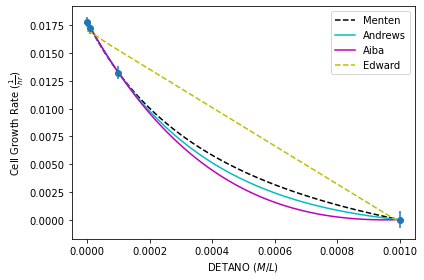

In [88]:
#Create figure to plot data and fitted funcitons onto
fig, ax = plt.subplots()

#Plot raw experimental data
if error == 'Yes':
    ax.errorbar(xdata, ydata, yerr=yerr, fmt='o')
else:
    ax.scatter(xdata, ydata, marker='o')

#Create dataframe into which variables are to be saved
ep_df = pd.DataFrame()

if exp_growth == 'Yes':
    #fit Menten function to data(S, mumax, Ks)
    #Making list of any additional bounds which may need to be applied
    ebounds = ([],[])
    #Fit function to data
    popMe, pcov = curve_fit(invmonod, xdata=xdata,ydata=ydata,sigma=yerr)
    #Having fit the function want to save associated fitting data to dataframe
    #Create list of variables associated with function
    var_list = ['mu_max', 'Ks']
    #append fitted values and statistics to global dataframe
    ep_df,r_squared = fit_figures(basal,var_list,popMe,'Inverse Monod',invmonod,ep_df)
    #Print out statement of fitted values and associated statistics for easy quick check
    if fit_print == 'Yes':
        print('Inverse Monod'+str(popMe))
        print('Inverse Monod r_squared='+str(r_squared))
    #Plot from fitted figures Menton model
    #check to make sure worth plotting
    if r_squared < min_r2:
        pass
    else:
        ax.plot(xdata_plot, invmonod(xdata_plot, *popMe), linestyle='--', color='k',label='Inverse Monod')

else:
        #Check if want to fit model
    if 'Menten' in models:
        #fit Menten function to data(S, mumax, Ks)
        #Making list of any additional bounds which may need to be applied
        ebounds = ([],[])
        #Fit function to data
        popMe, pcov = fitting(basal=basal,function=Menten,xdata=xdata,ydata=ydata,error=error,sigma=yerr,bounds=bounds,abounds=ebounds)
        #Having fit the function want to save associated fitting data to dataframe
        #Create list of variables associated with function
        var_list = ['mu_max', 'Ks']
        #append fitted values and statistics to global dataframe
        ep_df,r_squared = fit_figures(basal,var_list,popMe,'Menten',Menten,ep_df)
        #Print out statement of fitted values and associated statistics for easy quick check
        if fit_print == 'Yes':
            print('Menton'+str(popMe))
            print('Menton r_squared='+str(r_squared))
        #Plot from fitted figures Menton model
        #check to make sure worth plotting
        if r_squared < min_r2:
            pass
        else:
            ax.plot(xdata_plot, Menten(xdata_plot, *popMe), linestyle='--', color='k',label='Menten')
        
    #For Han and Luong need to to know Smin - this must be a value greater than the largest experimental x-axis value
    Smin = max(xdata)

    #Check if want to fit model
    if 'Han' in models:
        #Check if enough data points provided to fit function
        ebounds=([Smin,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
        #To check initially determine how many variables are being fitted
        if len(xdata) > 2+len(ebounds[0]):
            #fit Han function to data(S, mu_max, Ks, S_max, n, m)
            #Fit function to data
            popt, pcov = fitting(basal=basal,function=Han,xdata=xdata,ydata=ydata,error=error,sigma=yerr,bounds=bounds,abounds=ebounds)
            #Having fit the function want to save associated fitting data to dataframe
            #Create list of variables associated with function
            var_list = ['mu_max', 'Ks','S_max', 'n', 'm']
            #append fitted values and statistics to global dataframe
            ep_df,r_squared = fit_figures(basal,var_list,popt,'Han-Levenspiel',Han,ep_df)
            #Print out statement of fitted values and associated statistics for easy quick check
            if fit_print == 'Yes':
                print('Han'+str(popt))
                print('Han r_squared='+str(r_squared))
            #Plotting Han model
            #check to make sure worth plotting
            if r_squared < min_r2:
                pass
            else:
                ax.plot(xdata_plot, Han(xdata_plot, *popt), linestyle='-', color='k',label='Han-Levenspiel')

    #Check if want to fit model
    if 'Luong' in models:
        #Check if enough data points provided to fit function
        ebounds=([Smin,-np.inf],[np.inf,np.inf])
        if len(xdata) > 2+len(ebounds[0]):
            #fit Luong function to data (S, mu_max, Ks, S_max, n):
            popL, pcov = fitting(basal=basal,function=Luong,xdata=xdata,ydata=ydata,error=error,sigma=yerr,bounds=bounds,abounds=ebounds)
            #Having fit the function want to save associated fitting data to dataframe
            #Create list of variables associated with function
            var_list = ['mu_max', 'Ks','S_max', 'n']
            #append fitted values and statistics to global dataframe
            ep_df,r_squared = fit_figures(basal,var_list,popL,'Luong',Luong,ep_df)
            #Print out statement of fitted values and associated statistics for easy quick check
            if fit_print == 'Yes':
                print('Luong'+str(popL))
                print('Luong r_squared='+str(r_squared))
            #Plotting Luong model
            #check to make sure worth plotting
            if r_squared < min_r2:
                pass
            else:
                ax.plot(xdata_plot, Luong(xdata_plot, *popL), linestyle='-', color='g',label='Luong')

    #Check if want to fit model
    if 'Andrews' in models:
        #fit Andrews function to data (S,mu_max,Ks,Ki)
        ebounds=([1e-13],[np.inf])
        if len(xdata) > 2+len(ebounds[0]):
            popA, pcov = fitting(basal=basal,function=Andrews,xdata=xdata,ydata=ydata,error=error,sigma=yerr,bounds=bounds,abounds=ebounds)
            #Having fit the function want to save associated fitting data to dataframe
            #Create list of variables associated with function
            var_list = ['mu_max', 'Ks','Ki']
            #append fitted values and statistics to global dataframe
            ep_df,r_squared = fit_figures(basal,var_list,popA,'Andrews',Andrews,ep_df)
            #Print out statement of fitted values and associated statistics for easy quick check
            if fit_print == 'Yes':
                print('Andrews'+str(popA))
                print('Andrews r_squared='+str(r_squared))
            #Plotting Andrews model
            #check to make sure worth plotting
            if r_squared < min_r2:
                pass
            else:
                ax.plot(xdata_plot, Andrews(xdata_plot,*popA),linestyle='-', color='c',label='Andrews')

    #Check if want to fit model
    if 'Aiba' in models:
        #fit Aiba function to data (S,mu_max,Ks,Ki)
        ebounds=([0],[np.inf])
        if len(xdata) > 2+len(ebounds[0]):
            popAi, pcov = fitting(basal=basal,function=Aiba,xdata=xdata,ydata=ydata,error=error,sigma=yerr,bounds=bounds,abounds=ebounds)
            #Having fit the function want to save associated fitting data to dataframe
            #Create list of variables associated with function
            var_list = ['mu_max', 'Ks','Ki']
            #append fitted values and statistics to global dataframe
            ep_df,r_squared = fit_figures(basal,var_list,popAi,'Aiba',Aiba,ep_df)
            #Print out statement of fitted values and associated statistics for easy quick check
            if fit_print == 'Yes':
                print('Aiba'+str(popAi))
                print('Aiba r_squared='+str(r_squared))
            #Plotting Aiba model
            #check to make sure worth plotting
            if r_squared < min_r2:
                pass
            else:
                ax.plot(xdata_plot, Aiba(xdata_plot,*popAi),linestyle='-',  color='m',label='Aiba')
    
    #Check if want to fit model
    if 'Moser' in models:
        #fit Moser function to data (S,mu_max,Ks,n)
        ebounds=([0],[np.inf])
        if len(xdata) > 2+len(ebounds[0]):
            popM, pcov = fitting(basal=basal,function=Moser,xdata=xdata,ydata=ydata,error=error,sigma=yerr,bounds=bounds,abounds=ebounds)
            #Having fit the function want to save associated fitting data to dataframe
            #Create list of variables associated with function
            var_list = ['mu_max', 'Ks','n']
            #append fitted values and statistics to global dataframe
            ep_df,r_squared = fit_figures(basal,var_list,popM,'Moser',Moser,ep_df)
            #Print out statement of fitted values and associated statistics for easy quick check
            if fit_print == 'Yes':
                print('Moser'+str(popM))
                print('Moser r_squared='+str(r_squared))
            #Plotting Moser model
            #check to make sure worth plotting
            if r_squared < min_r2:
                pass
            else:
                ax.plot(xdata_plot, Moser(xdata_plot,*popM),linestyle='-',  color='y',label='Moser')

    #Check if want to fit model
    if 'Edward' in models:
        #fit Edward function to data (S,mu_max,Ks,Ki)
        ebounds=([1e-13],[np.inf])
        if len(xdata) > 2+len(ebounds[0]):
            popE, pcov = fitting(basal=basal,function=Edward,xdata=xdata,ydata=ydata,error=error,sigma=yerr,bounds=bounds,abounds=ebounds)
            #Having fit the function want to save associated fitting data to dataframe
            #Create list of variables associated with function
            var_list = ['mu_max', 'Ks','Ki']
            #append fitted values and statistics to global dataframe
            ep_df,r_squared = fit_figures(basal,var_list,popE,'Edward',Edward,ep_df)
            #Print out statement of fitted values and associated statistics for easy quick check
            if fit_print == 'Yes':
                print('Edward'+str(popE))
                print('Edwards r_squared='+str(r_squared))
            #Plotting Edwards model
            #check to make sure worth plotting
            if r_squared < min_r2:
                pass
            else:
                ax.plot(xdata_plot, Edward(xdata_plot,*popE), linestyle='--', color='y',label='Edward')

    #Check if want to fit model
    if 'Webb' in models:
        #fit Webb function to data (S,mu_max,Ks,Ki,K)
        ebounds=([1e-13,-np.inf],[np.inf,np.inf])
        if len(xdata) > 2+len(ebounds[0]):
            popW, pcov = fitting(basal=basal,function=Webb,xdata=xdata,ydata=ydata,error=error,sigma=yerr,bounds=bounds,abounds=ebounds)
            #Having fit the function want to save associated fitting data to dataframe
            #Create list of variables associated with function
            var_list = ['mu_max', 'Ks','Ki','K']
            #append fitted values and statistics to global dataframe
            ep_df,r_squared = fit_figures(basal,var_list,popW,'Webb',Webb,ep_df)
            #Print out statement of fitted values and associated statistics for easy quick check
            if fit_print == 'Yes':
                print('Webb'+str(popW))
                print('Webb r_squared='+str(r_squared))
            #Plotting Webb model
            #check to make sure worth plotting
            if r_squared < min_r2:
                pass
            else:
                ax.plot(xdata_plot, Webb(xdata_plot,*popW), linestyle='--', color='b',label='Webb')

    #Check if want to fit model
    if 'Yano' in models:
        #fit Yano function to data (S,mu_max,Ks,Ki,K)
        ebounds=([1e-13,-np.inf],[np.inf,np.inf])
        if len(xdata) > 2+len(ebounds[0]):
            popY, pcov = fitting(basal=basal,function=Yano,xdata=xdata,ydata=ydata,error=error,sigma=yerr,bounds=bounds,abounds=ebounds)
            #Having fit the function want to save associated fitting data to dataframe
            #Create list of variables associated with function
            var_list = ['mu_max', 'Ks','Ki','K']
            #append fitted values and statistics to global dataframe
            ep_df,r_squared = fit_figures(basal,var_list,popY,'Yano',Yano,ep_df)
            #Print out statement of fitted values and associated statistics for easy quick check
            if fit_print == 'Yes':
                print('Yano'+str(popY))
                print('Yano r_squared='+str(r_squared))
            #Plotting Yano model
            #check to make sure worth plotting
            if r_squared < min_r2:
                pass
            else:
                ax.plot(xdata_plot, Yano(xdata_plot,*popY), linestyle='--', color='r',label='Yano')

    #Check if want to fit model
    if 'Haldane' in models:
        #fit Haldane function to data (S,mu_max,Ks,S_max,Ki)
        ebounds=([1e-13,Smin],[np.inf,np.inf])
        if len(xdata) > 2+len(ebounds[0]):
            popHa, pcov = fitting(basal=basal,function=Haldane,xdata=xdata,ydata=ydata,error=error,sigma=yerr,bounds=bounds,abounds=ebounds)
            #Having fit the function want to save associated fitting data to dataframe
            #Create list of variables associated with function
            var_list = ['mu_max', 'Ks','S_max','Ki']
            #append fitted values and statistics to global dataframe
            ep_df,r_squared = fit_figures(basal,var_list,popHa,'Haldane',Haldane,ep_df)
            #Print out statement of fitted values and associated statistics for easy quick check
            if fit_print == 'Yes':
                print('Haldane'+str(popHa))
                print('Haldane r_squared='+str(r_squared))
            #Plotting Haldane model
            #check to make sure worth plotting
            if r_squared < min_r2:
                pass
            else:
                ax.plot(xdata_plot, Haldane(xdata_plot,*popHa), linestyle='--', color='m',label='Haldane')

#Save out global fitted function value dataframe
#Move model column to be first column for ease of reading
ep_df.insert(0, 'Model', ep_df.pop('model'))
#Reorder models based on R^2 value
ep_df = ep_df.sort_values(by=['R Squared'],ascending=False)
#Reset pandas dataframe index
ep_df = ep_df.reset_index(drop=True)
#Specify data save location
data_loc = root+'data/'
#make sure data file location exists
checkdir(data_loc)
#Save dataframe out 
ep_df.to_csv(data_loc+data_name+'.csv')
#Print dataframe for ease of quick check
print(ep_df)
    
#Set labels of plot
ax.set(xlabel=xlabel, ylabel=ylabel)
#plotting legend 
if legend_plot == 'Yes':
    plt.legend()

#Set axis bounds of plot
#Axis limits in figure
#X-axis
xmin = 0
xmax = max(xdata)*1.2
#Y-axis
ymax = 0
ymin = max(ydata)*1.2
#setting bounds
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([ymax,ymin])
#Make figure tight
fig.tight_layout()
#Specify figure save location
figure_loc = root+'figures/'
#make sure figure save location exists
checkdir(figure_loc)
#Save figure out
fig.savefig(figure_loc+figure_name, dpi=300)